### Facial keypoints detection

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from keras.metrics import RootMeanSquaredError
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import cv2

#### Constants

In [2]:
img_height, img_width = 96, 96

#### Dataset loading

The given dataset has already been separated to the train and the test part (2 .csv files zipped for the sake of good memory utilization). 
`train` and `test` archives contains .csv file with coordinates of each keypoint as well as the image.

In [3]:
train = pd.read_csv('./dataset/training.zip', compression='zip')
test = pd.read_csv('./dataset/test.zip', compression='zip')
IdLookupTable = pd.read_csv('./dataset/IdLookupTable.csv', header=0, sep=',', quotechar='"')

Each keypoint is specified by an (x, y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

*left_eye_center*, *right_eye_center*, *left_eye_inner_corner*, *left_eye_outer_corner*, *right_eye_inner_corner*, *right_eye_outer_corner*, *left_eyebrow_inner_end*, *left_eyebrow_outer_end*, *right_eyebrow_inner_end*, *right_eyebrow_outer_end*, *nose_tip*, *mouth_left_corner*, *mouth_right_corner*, *mouth_center_top_lip*, *mouth_center_bottom_lip*

Left and right here refers to the point of view of the subject.

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

##### Train dataset preview
Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

In [4]:
print('The number of samples into the train data is {}.'.format(train.shape[0]))

train.head().T

The number of samples into the train data is 7049.


,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


##### Test dataset preview
Each row contains ImageId and image data as row-ordered list of pixels

In [5]:
print('The number of samples into the test data is {}.'.format(test.shape[0]))

test.head()

The number of samples into the test data is 1783.


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


#### Data preprocessing - missing values

In [6]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [7]:
print('Maximal number of missing columns is %d, which is %.2f%%' %(max(train.isnull().sum()), 100. * max(train.isnull().sum()) / train.shape[0]))

Maximal number of missing columns is 4824, which is 68.44%


##### Dropping missing values
First technique can be to drop all missing values. This will drop almost ~70% of the training dataset so it wont be used.

In [8]:
def drop_missing_values():  
    train_dropped_missing_values = train.dropna()
    return train_dropped_missing_values

##### Fill missing values
The forward fill method (ffill) fills in missing values with the previous value in the column. It "propagates" the previous value forward. Common choices for filling in the missing values, such as mean or median, do not apply well here, because the mean of every key point will not represent anything. On the other hand, images from the dataset are quite similar to each others, so filling in some key points to be positioned as same as the previous similar key point will not make a colossal mistake. 

In [9]:
def fill_missing_values():  
    train_filled_values = train.fillna(method = 'ffill', inplace=False)
    return train_filled_values

In [10]:
def solve_missing_values(method: str):
    if method == 'drop':
        return drop_missing_values()
    elif method == 'ffill':
        return fill_missing_values()

##### Solve missing values

In [11]:
train_no_missing_values = solve_missing_values('ffill')

In [12]:
number_of_rows_train, number_of_columns_train = train_no_missing_values.shape
print('Shape of train data without any missing values are ({}, {}).'.format(number_of_rows_train , number_of_columns_train))
train_no_missing_values.isnull().sum().any()

Shape of train data without any missing values are (7049, 31).


False

There is no missing values any more!

#### Images and keypoints preview

The last column (accessed using the name `Image`) of the train dataset represents an image. If there are any blank spaces, represents by null values, in the pixels they will be replaced with 0. The pixel values will be normalized in the range [0, 1].

In [13]:
images = []
labels = []

for index, sample in train_no_missing_values.iterrows():

    face_pixel = np.array(sample['Image'].split(' '), dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    images.append(face_pixel)

    labels.append(sample[0:30])

images = np.array(images)
labels = np.array(labels, dtype = 'float')

images.shape, labels.shape

((7049, 96, 96, 1), (7049, 30))

(96, 96)


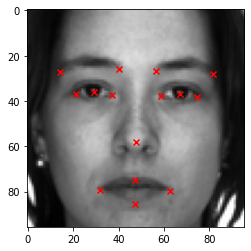

In [14]:
sample_image_number = 1235
img_for_show = np.squeeze(images[sample_image_number])
print(img_for_show.shape)
plt.imshow(img_for_show, cmap='gray')
plt.scatter(labels[sample_image_number][0:30:2], labels[sample_image_number][1:30:2], marker='x', c = 'red')
plt.show()

#### Model

Testset will be splitted into 3 groups: train, validate, test. The relative size of each group will be the following (train, validate, test) = (90%, 5%, 5%)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print('Shape of train dataset is ({}, {}).'.format(X_train.shape, y_train.shape))
print('Shape of validation dataset is ({}, {}).'.format(X_val.shape, y_val.shape))
print('Shape of test dataset is ({}, {}).'.format(X_test.shape, y_test.shape))


Shape of train dataset is ((6344, 96, 96, 1), (6344, 30)).
Shape of validation dataset is ((352, 96, 96, 1), (352, 30)).
Shape of test dataset is ((353, 96, 96, 1), (353, 30)).


Hence this dataset is small (~10<sup>4</sup> inputs) this division will work fine.

In [16]:
def plot_loss(history, model_name, plt):
    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(loss, "--", linewidth=3, label="train [" + model_name + "]")
    plt.plot(val_loss, linewidth=3, label="val [" + model_name + "]")
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("log loss")
    plt.title("Loss graphic for " + model_name + " model")
    plt.savefig(model_name + "_loss.png", dpi=90)
    plt.show()

##### Neural Netowrk

In [17]:
model_nn = Sequential(name="DeepNN")

model_nn.add(Flatten(input_shape=(96, 96, 1)))

model_nn.add(Dense(1024, activation='relu'))

model_nn.add(Dense(512, activation='relu'))

model_nn.add(Dense(256, activation='relu'))

model_nn.add(Dense(128, activation='relu'))

model_nn.add(Dense(64, activation='relu'))

model_nn.add(Dense(64, activation='relu'))

model_nn.add(Dense(30))

plot_model(model_nn, to_file='DeepNN.png', show_shapes=True)

model_nn.summary()

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 1024)              9438208   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 64)                4160 

In [18]:
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [19]:
history_nn = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                            epochs=100, 
                            batch_size=32, 
                            shuffle=True)

Epoch 1/100
199/199 [==============================] - 4s 7ms/step - loss: 1799.6198 - root_mean_squared_error: 42.4219 - accuracy: 0.1516 - mae: 21.2376 - val_loss: 178.4511 - val_root_mean_squared_error: 13.3586 - val_accuracy: 0.0000e+00 - val_mae: 10.4075
Epoch 2/100
199/199 [==============================] - 1s 6ms/step - loss: 156.6268 - root_mean_squared_error: 12.5151 - accuracy: 0.3707 - mae: 9.6265 - val_loss: 145.0725 - val_root_mean_squared_error: 12.0446 - val_accuracy: 0.2955 - val_mae: 9.2856
Epoch 3/100
199/199 [==============================] - 1s 6ms/step - loss: 134.8425 - root_mean_squared_error: 11.6122 - accuracy: 0.3641 - mae: 8.8749 - val_loss: 144.6060 - val_root_mean_squared_error: 12.0252 - val_accuracy: 0.0256 - val_mae: 9.1843
Epoch 4/100
199/199 [==============================] - 1s 5ms/step - loss: 119.7171 - root_mean_squared_error: 10.9415 - accuracy: 0.3791 - mae: 8.2716 - val_loss: 220.4585 - val_root_mean_squared_error: 14.8478 - val_accuracy: 0.6705

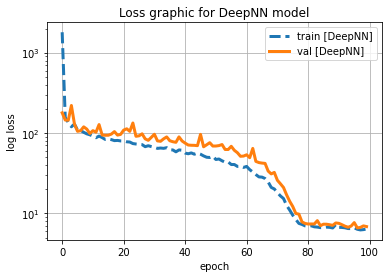

In [20]:
plot_loss(history_nn.history, model_nn.name, plt)

In [21]:
print("All metrics: {}.".format(model_nn.metrics_names))
evaluations_nn = model_nn.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_nn.name, evaluations_nn[model_nn.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 0s 3ms/step - loss: 5.3295 - root_mean_squared_error: 2.3086 - accuracy: 0.7422 - mae: 1.3292
Accuracy of DeepNN model is: 0.7422%


#### Convolution Neural Network

Due to limits of the dataset size, LeNet-5 convolutional neural network [LeCun et al. 1998] is choosen. The network architecture of LeNet-5 is relatively simple, consisting of 7 layers: two convolutional layers, two subsampling layers (maxpool), and three fully connected layers. LeNet-5 is relatively efficient in terms of computational power and memory requirements.

In [22]:
model_lenet = Sequential(name="LeNet-5")

model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 1)))
model_lenet.add(MaxPool2D(pool_size=(2, 2)))

model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet.add(MaxPool2D(pool_size=(2, 2)))

model_lenet.add(Flatten())

model_lenet.add(Dense(120, activation='relu'))

model_lenet.add(Dense(84, activation='relu'))

model_lenet.add(Dense(30))

plot_model(model_lenet, to_file='LeNet-5.png', show_shapes=True)

model_lenet.summary()


Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7056)              0         
                                                                 
 dense_7 (Dense)             (None, 120)               8468

In [23]:
model_lenet.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [24]:
history_lenet = model_lenet.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
199/199 [==============================] - 7s 7ms/step - loss: 207.4066 - root_mean_squared_error: 14.4016 - accuracy: 0.5019 - mae: 9.5551 - val_loss: 92.3660 - val_root_mean_squared_error: 9.6107 - val_accuracy: 0.6705 - val_mae: 7.1261
Epoch 2/100
199/199 [==============================] - 1s 6ms/step - loss: 83.4608 - root_mean_squared_error: 9.1357 - accuracy: 0.6217 - mae: 6.8267 - val_loss: 83.3851 - val_root_mean_squared_error: 9.1315 - val_accuracy: 0.6562 - val_mae: 6.6892
Epoch 3/100
199/199 [==============================] - 1s 5ms/step - loss: 69.0712 - root_mean_squared_error: 8.3109 - accuracy: 0.6335 - mae: 6.1529 - val_loss: 75.9669 - val_root_mean_squared_error: 8.7159 - val_accuracy: 0.6648 - val_mae: 6.2356
Epoch 4/100
199/199 [==============================] - 1s 5ms/step - loss: 62.3437 - root_mean_squared_error: 7.8958 - accuracy: 0.6543 - mae: 5.8372 - val_loss: 75.1276 - val_root_mean_squared_error: 8.6676 - val_accuracy: 0.6705 - val_mae: 6.3092
Ep

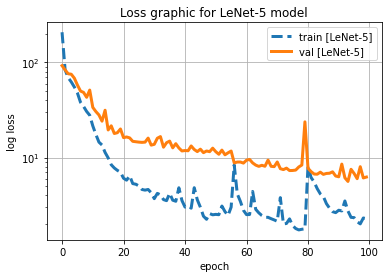

In [25]:
plot_loss(history_lenet.history, model_lenet.name, plt)

In [26]:
print("All metrics: {}.".format(model_lenet.metrics_names))
evaluations_lenet = model_lenet.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_lenet.name, evaluations_lenet[model_lenet.metrics_names.index('accuracy')]))


All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 0s 7ms/step - loss: 4.6795 - root_mean_squared_error: 2.1632 - accuracy: 0.7875 - mae: 1.3536
Accuracy of LeNet-5 model is: 0.7875%


#### Visually evaluate the model

The DeepNN model gives ~72% while the LeNet-5 gives the ~77% accuracy. Both models will be visually evaluated on 20 images from unlabeled dataset.


DeepNN

In [27]:
def visually_evaluate_model(model_for_submission):
    images_for_submission = []

    for index, sample in test.iterrows():

        face_pixel = np.array(sample['Image'].split(' '), dtype='float')
        face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
        images_for_submission.append(face_pixel)

    images_for_submission = np.array(images_for_submission)

    print('Shape of dataset for visually testing {}.'.format(images_for_submission.shape))

    predictions = model_for_submission.predict(images_for_submission)

    fig = plt.figure(figsize=(20,16))
    for i in range(20):
        image = images_for_submission[i].reshape(96,96)
        axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        axis.imshow(image, cmap='gray')
        axis.scatter(predictions[i][0::2], predictions[i][1::2], marker='x', c = 'red')
    plt.show()

Shape of dataset for visually testing (1783, 96, 96, 1).
56/56 [==============================] - 0s 2ms/step


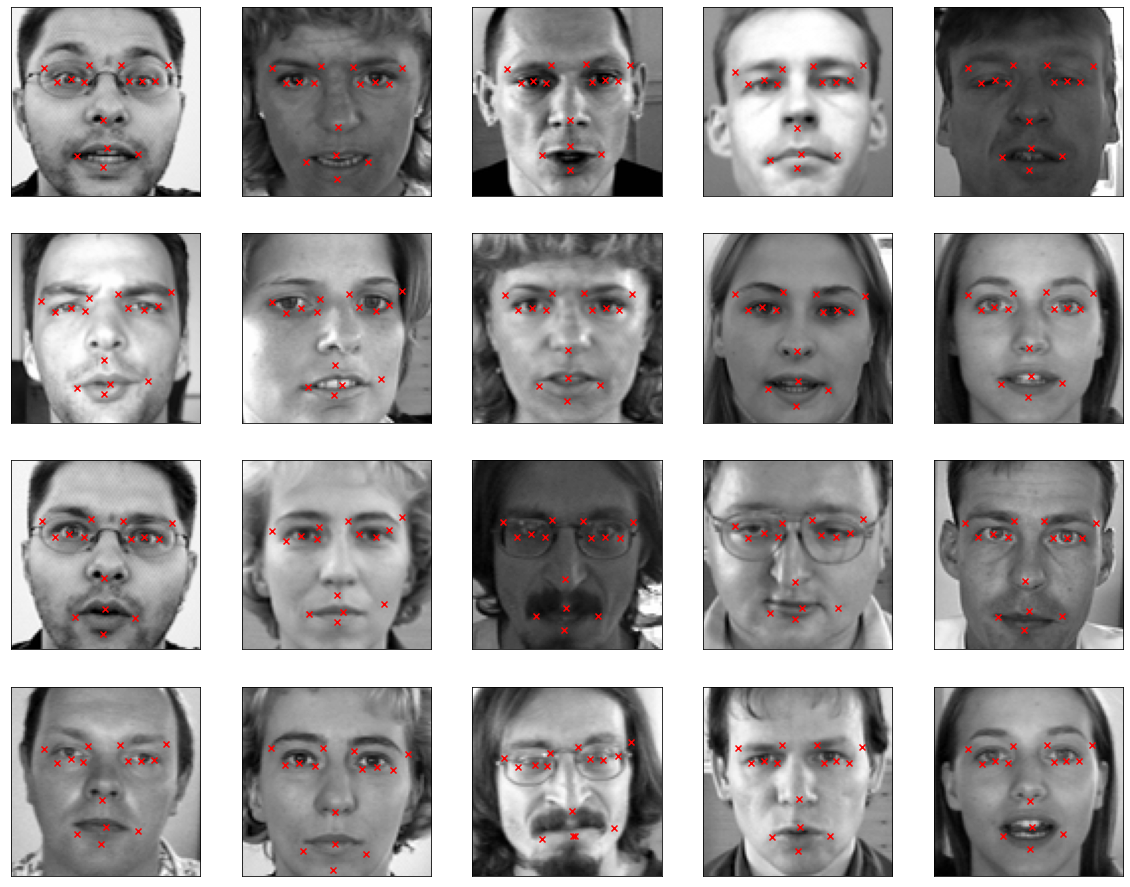

In [28]:
visually_evaluate_model(model_nn)

Shape of dataset for visually testing (1783, 96, 96, 1).
56/56 [==============================] - 0s 3ms/step


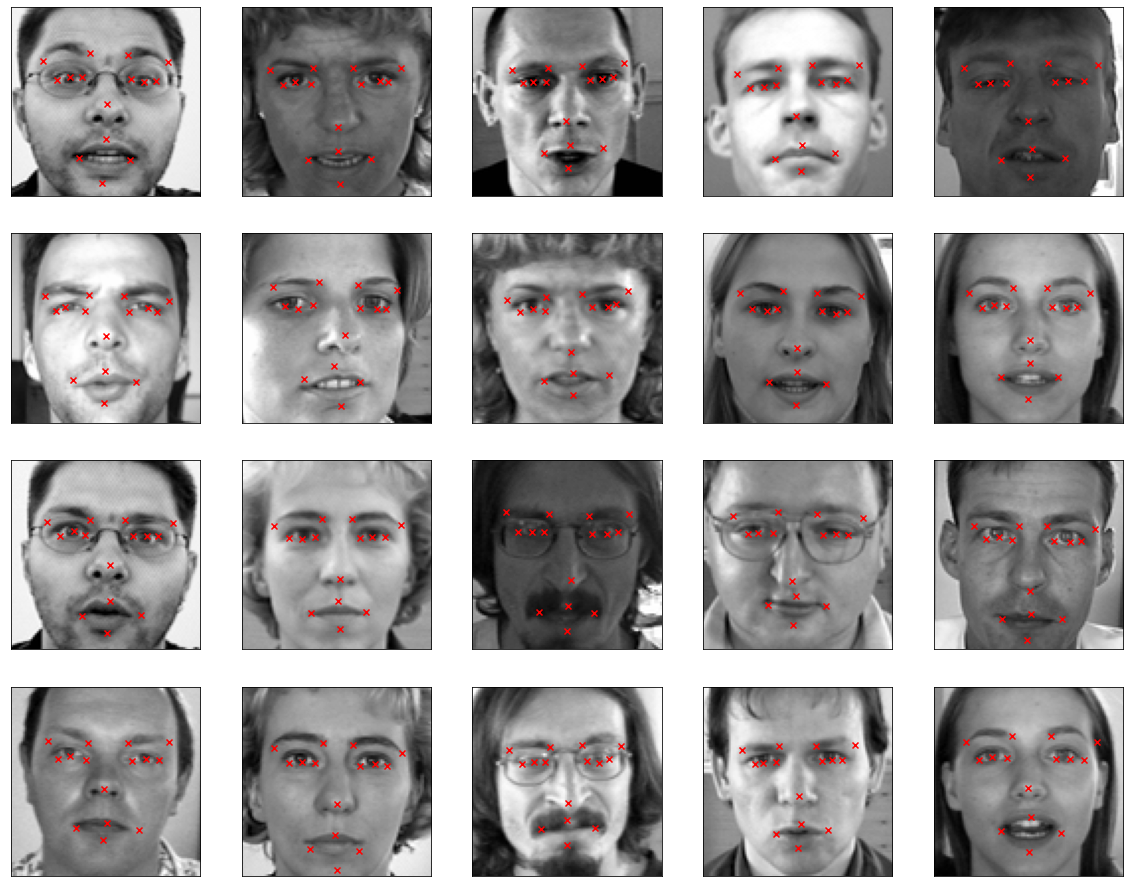

In [29]:
visually_evaluate_model(model_lenet)

Kaggle submission will be generated using LeNet-5 neural network, because it has better accuracy.

In [30]:
model_for_submission = model_lenet

images_for_submission = []

for index, sample in test.iterrows():

    face_pixel = np.array(sample['Image'].split(' '), dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    images_for_submission.append(face_pixel)

images_for_submission = np.array(images_for_submission)

predictions = model_for_submission.predict(images_for_submission)

56/56 [==============================] - 0s 2ms/step


In [31]:
feature_names = list(IdLookupTable['FeatureName'])
image_ids = list(IdLookupTable['ImageId']-1)
row_ids = list(IdLookupTable['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

In [32]:
predictions_for_submission = []
for x,y in zip(image_ids, feature_list):
    predictions_for_submission.append(predictions[x][y])

In [33]:
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions_for_submission, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('dataset/submission.csv',index = False)

#### My Image

Better represent

In [34]:
def predict_my_image(image_path):
    my_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2GRAY)
    my_gray_image = gray_image.reshape(96, 96, 1)
    my_gray_image = np.array(my_gray_image, dtype='float')

    im = []

    face_pixel = np.array(my_gray_image, dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    im.append(face_pixel)

    im = np.array(im)

    preds = model_for_submission.predict(im)

    image = im[0].reshape(96,96)
    plt.imshow(image, cmap='gray')
    plt.scatter(preds[0][0::2], preds[0][1::2], marker='x', c = 'red')
    plt.show()

1/1 [==============================] - 0s 14ms/step


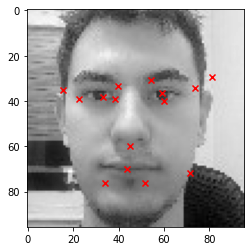

In [57]:
predict_my_image("dataset/mdodovic1.jpg")

1/1 [==============================] - 0s 15ms/step


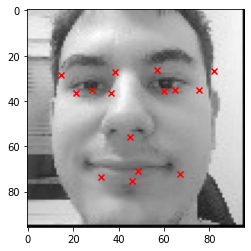

In [58]:
predict_my_image("dataset/mdodovic2.jpg")

1/1 [==============================] - 0s 15ms/step


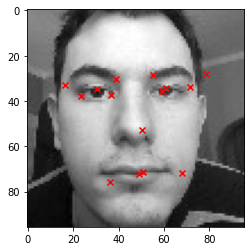

In [60]:
predict_my_image("dataset/mdodovic6.jpg")

1/1 [==============================] - 0s 34ms/step


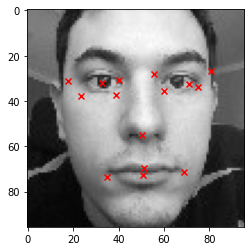

In [61]:
predict_my_image("dataset/mdodovic7.jpg")

#### Additional Models

#### AlexNet

In [39]:
model_alexnet = Sequential(name="AlexNet")

model_alexnet.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(96, 96, 1), padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

model_alexnet.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

model_alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(MaxPool2D(pool_size=(3, 3), strides=2))

model_alexnet.add(Flatten())

model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))

model_alexnet.add(Dense(30))

plot_model(model_alexnet, to_file='AlexNet.png', show_shapes=True)

model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 96)        11712     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 384)         1327

In [40]:
model_alexnet.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [41]:
history_alexnet = model_alexnet.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
199/199 [==============================] - 5s 20ms/step - loss: 508.8533 - root_mean_squared_error: 22.5578 - accuracy: 0.2831 - mae: 14.8565 - val_loss: 92.0474 - val_root_mean_squared_error: 9.5941 - val_accuracy: 0.6705 - val_mae: 7.1062
Epoch 2/100
199/199 [==============================] - 4s 18ms/step - loss: 104.8938 - root_mean_squared_error: 10.2418 - accuracy: 0.4185 - mae: 7.7729 - val_loss: 36.6472 - val_root_mean_squared_error: 6.0537 - val_accuracy: 0.6705 - val_mae: 4.4399
Epoch 3/100
199/199 [==============================] - 4s 19ms/step - loss: 36.2203 - root_mean_squared_error: 6.0183 - accuracy: 0.4693 - mae: 4.5207 - val_loss: 9.2221 - val_root_mean_squared_error: 3.0368 - val_accuracy: 0.6705 - val_mae: 1.8620
Epoch 4/100
199/199 [==============================] - 4s 18ms/step - loss: 28.0553 - root_mean_squared_error: 5.2967 - accuracy: 0.4957 - mae: 3.9783 - val_loss: 11.2480 - val_root_mean_squared_error: 3.3538 - val_accuracy: 0.6705 - val_mae: 2.2

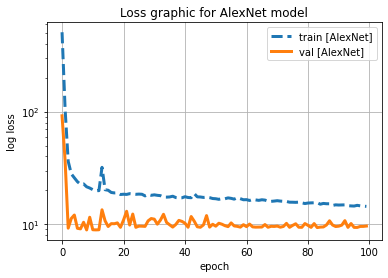

In [42]:
plot_loss(history_alexnet.history, model_alexnet.name, plt)

In [43]:
print("All metrics: {}.".format(model_alexnet.metrics_names))
evaluations_alexnet = model_alexnet.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model_alexnet.name, evaluations_alexnet[model_alexnet.metrics_names.index('accuracy')]))

All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 0s 22ms/step - loss: 8.5840 - root_mean_squared_error: 2.9298 - accuracy: 0.6091 - mae: 1.9349
Accuracy of AlexNet model is: 0.6091%


#### VGG-16

In [44]:
model = Sequential(name="VGG-16")

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1), padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(30))

plot_model(model, to_file='VGG-16.png', show_shapes=True)

model.summary()


Model: "VGG-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        640       
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                        

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), 'accuracy', 'mae'])

In [46]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=100, 
                                batch_size=32, 
                                shuffle=True)

Epoch 1/100
199/199 [==============================] - 24s 107ms/step - loss: 37621.4375 - root_mean_squared_error: 193.9625 - accuracy: 0.2656 - mae: 30.6161 - val_loss: 16.8206 - val_root_mean_squared_error: 4.1013 - val_accuracy: 0.2955 - val_mae: 3.2272
Epoch 2/100
199/199 [==============================] - 20s 102ms/step - loss: 49.3786 - root_mean_squared_error: 7.0270 - accuracy: 0.4440 - mae: 5.3611 - val_loss: 9.3210 - val_root_mean_squared_error: 3.0530 - val_accuracy: 0.6705 - val_mae: 1.9171
Epoch 3/100
199/199 [==============================] - 20s 101ms/step - loss: 42.5891 - root_mean_squared_error: 6.5260 - accuracy: 0.5058 - mae: 4.9288 - val_loss: 13.3000 - val_root_mean_squared_error: 3.6469 - val_accuracy: 0.6705 - val_mae: 2.7377
Epoch 4/100
199/199 [==============================] - 20s 101ms/step - loss: 39.7144 - root_mean_squared_error: 6.3019 - accuracy: 0.5429 - mae: 4.7349 - val_loss: 9.5304 - val_root_mean_squared_error: 3.0871 - val_accuracy: 0.6705 - val_

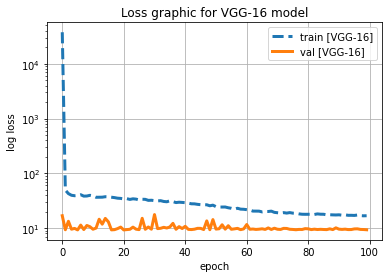

In [47]:
plot_loss(history.history, model.name, plt)

In [48]:
print("All metrics: {}.".format(model.metrics_names))
evaluations = model.evaluate(X_test, y_test)
print("Accuracy of {} model is: {:0.4f}%".format(model.name, evaluations[model.metrics_names.index('accuracy')]))

All metrics: ['loss', 'root_mean_squared_error', 'accuracy', 'mae'].
12/12 [==============================] - 1s 58ms/step - loss: 8.2130 - root_mean_squared_error: 2.8658 - accuracy: 0.6091 - mae: 1.8632
Accuracy of VGG-16 model is: 0.6091%
